# Реализация схемы с весами для уравнения теплопроводности

Рассмотрим обобщенную двухслойную разностную схему с весом `σ` для аппроксимации уравнения теплопроводности `∂u/∂t = ∂²u/∂x² + f(x, t)` (или его многомерного аналога). На сетке `(x_i, t_j)` схема имеет вид:

$$
\frac{y_i^{j+1} - y_i^j}{\tau} = \sigma (\Lambda y^{j+1})_i + (1-\sigma) (\Lambda y^j)_i + (\varphi)_i
$$

где:
*   `y_i^j` ≈ `u(x_i, t_j)` – значение сеточной функции в узле `(i, j)`.
*   `τ` – шаг по времени (`t_{j+1} = t_j + τ`).
*   `Λ` – сеточный оператор, аппроксимирующий пространственные производные (например, `(Λy)_i = (y_{i+1} - 2y_i + y_{i-1})/h^2` для 1D Лапласиана с шагом `h`).
*   `σ` – весовой параметр схемы (`0 ≤ σ ≤ 1`).
*   `φ` – аппроксимация правой части (источника) `f(x, t)`. Часто используется взвешенное значение: `(\varphi)_i = f(x_i, t_j + \sigma \tau)`. В записях на изображении это обозначено как `f_σ`.

**Интерпретация и частные случаи:**

Эта схема представляет собой "взвешенное" по времени усреднение пространственного оператора `Λ`. Параметр `σ` контролирует степень неявности схемы:

1.  **`σ = 0` (Явная схема):**
    $$ \frac{y^{j+1} - y^j}{\tau} = \Lambda y^j + \varphi^j $$
    Схема полностью явная. Значения на новом слое `j+1` вычисляются напрямую через известный слой `j`. Условно устойчива. Порядок аппроксимации `O(τ + h^2)`.

2.  **`σ = 1` (Полностью неявная схема):**
    $$ \frac{y^{j+1} - y^j}{\tau} = \Lambda y^{j+1} + \varphi^{j+1} $$
    Схема полностью неявная. Для нахождения `y^{j+1}` требуется решение системы линейных уравнений на каждом шаге. Абсолютно устойчива. Порядок аппроксимации `O(τ + h^2)`.

3.  **`σ = 0.5` (Схема Кранка-Николсон):**
    $$ \frac{y^{j+1} - y^j}{\tau} = \frac{1}{2} (\Lambda y^{j+1} + \Lambda y^j) + \varphi^{j+1/2} $$
    (Как показано в синем блоке на изображении). Симметричная схема, неявная. Абсолютно устойчива. Имеет повышенный порядок аппроксимации по времени: `O(τ² + h^2)`.

### Решаемое уравнение

В предоставленном коде численно решается **начально-краевая задача для одномерного уравнения теплопроводности**.

Уравнение в частных производных имеет вид:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}
$$

**Область решения:**
*   Пространственная переменная: `x ∈ [0, L]`, где `L = x_border` (в коде `L = π`).
*   Временная переменная: `t ∈ [0, T]`, где `T = t_border` (в коде `T = 1`).

**Начальное условие:**
Задается распределение температуры (или концентрации) в начальный момент времени `t=0`:
$$
u(x, 0) = \phi(x), \quad x \in [0, L]
$$
В последней версии кода используется функция `phi_truncated(x)`, которая представляет собой сумму первых `N=3` членов ряда Фурье, соответствующего аналитическому решению задачи с начальным условием `u(x,0) = x(\pi-x)`:
$$
\phi_{trunc}(x) = \sum_{n=1}^{N} \frac{8(1 - (-1)^n)}{\pi n^3} \sin(nx)
$$

**Граничные условия:**
Задаются значения функции на границах пространственной области для всех моментов времени `t > 0`. Используются однородные граничные условия первого рода (условия Дирихле):
$$
u(0, t) = 0 \quad (\text{функция } l\_bound(t))
$$
$$
u(L, t) = 0 \quad (\text{функция } r\_bound(t))
$$
Это означает, что температура на концах стержня поддерживается равной нулю.

## Реализация схемы с весами и её визуализация

Решение уравнения с помощью разностной схемы


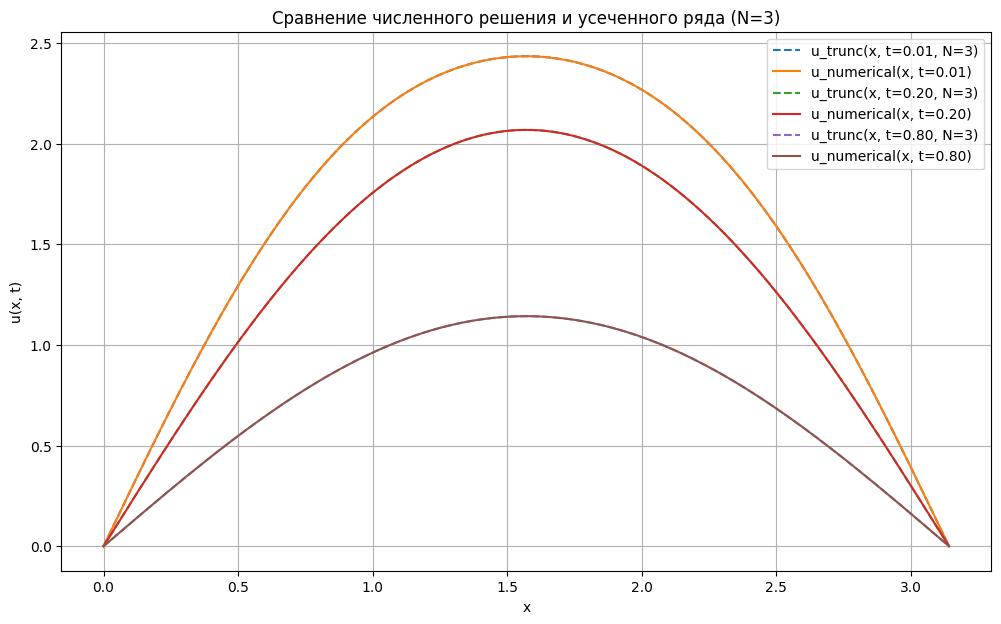

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm


# --- Аналитическое решение (усеченный ряд) ---
N_TERMS = 3 # Задаем количество слагаемых
def u_truncated(x, t, num_terms=N_TERMS):
    total = 0.0
    for n in range(1, num_terms + 1):
        coefficient = 8 * (1 - (-1)**n) / (np.pi * n**3)
        if coefficient == 0:
            continue
        exponent = -n**2 * t
        total += coefficient * np.exp(exponent) * np.sin(n * x)
    return total / 2


def weighted_scheme(a: int, f, phi,
                    l_bound, r_bound,
                    sigma = 1/2,
                    x_border = 1, t_border = 1,
                    x_num = int(1e3), t_num = int(1e3)) -> np.ndarray:

    t_grid = np.linspace(0, t_border, t_num)
    x_grid = np.linspace(0, x_border, x_num)
    l_bound_gr = np.array([l_bound(t) for t in t_grid])
    r_bound_gr = np.array([r_bound(t) for t in t_grid])
    h = x_border / (x_num - 1)
    tau = t_border / (t_num - 1)
    a_2 = a**2
    h_2 = h**2

    solution_grid = np.zeros((t_num, x_num))

    def tma(A, b):
        n = A.shape[0]
        x = np.zeros(n, dtype=np.double)
        alpha = np.zeros(n, dtype=np.double)
        beta = np.zeros(n, dtype=np.double)
        alpha[0] = -A[0, 1] / A[0, 0]
        beta[0] = b[0] / A[0, 0]
        for i in range(1, n):
            denominator = A[i, i] + A[i, i - 1] * alpha[i - 1]
            alpha[i] = -A[i, i + 1] / denominator if i < n - 1 else 0
            beta[i] = (b[i] - A[i, i - 1] * beta[i - 1]) / denominator
        x[n - 1] = beta[n - 1]
        for i in range(n - 2, -1, -1):
            x[i] = alpha[i] * x[i + 1] + beta[i]
        return x

    def next_layer(y_j:np.ndarray, t_layer) -> np.ndarray:
        A = np.zeros((x_num, x_num))
        b = np.zeros(x_num)
        A[0][0] = 1
        A[-1][-1] = 1
        b[0] =  l_bound_gr[t_layer]
        b[-1] = r_bound_gr[t_layer]
        current_t = tau * t_layer
        f_values = f(x_grid, current_t + sigma*tau) 
        
        for index in range(1, x_num - 1):
            A[index][index - 1] = -sigma*a_2/h_2
            A[index][index] = (1 / tau + 2*sigma*a_2/h_2)
            A[index][index + 1] = -sigma*a_2/h_2

            b[index] = (
                        y_j[index]/tau
                        + (1 - sigma)*a_2/h_2*(y_j[index + 1] - 2*y_j[index] + y_j[index - 1])
                        + f_values[index] 
                    )
        return tma(A, b)

    solution_grid[0] = phi(x_grid)
    for t_layer in tqdm(range(1, t_num), desc="Расчёт слоёв", leave=False):
        solution_grid[t_layer] = next_layer(solution_grid[t_layer - 1],
                                            t_layer)

    return solution_grid, x_grid, t_grid

def f_zer(x,t):
    return np.zeros_like(x) if isinstance(x, np.ndarray) else 0.0

def phi_truncated(x, num_terms=N_TERMS):
    total = 0.0
    for n in range(1, num_terms + 1):
        coefficient = 8 * (1 - (-1)**n) / (np.pi * n**3)
        if coefficient == 0:
            continue
        total += coefficient * np.sin(n * x)
    return total / 2

def l_bound(t):
    return  0

def r_bound(t):
    return 0

# --- Параметры симуляции ---
t_border = 1
x_border = np.pi
sigma = 0.5      # Схема Кранка-Николсон
a_coeff = 1      # Коэффициент температуропроводности
x_num = int(1e3) # Увеличим для точности примера
t_num = int(1e3) # Увеличим для точности примера

# --- Расчет с новыми условиями ---
print("Решение уравнения с помощью разностной схемы")
my_solution, x_values, t_values = weighted_scheme(a_coeff, f_zer, phi_truncated,
                l_bound, r_bound,
                sigma = sigma,
                x_border = x_border , t_border = t_border,
                x_num = x_num, t_num = t_num)


# --- Построение графиков сравнения ---
t_grid_ind = [int(0.01*t_num), int(0.2*t_num), int(0.8*t_num)] # Индексы временных слоев для графика

plt.figure(figsize=(12, 7))

for ind in t_grid_ind:
    current_t = t_values[ind]
    # Вычисляем точное усеченное решение
    u_trunc_values = u_truncated(x_values, current_t, num_terms=N_TERMS)
    solution_for_graph = my_solution[ind, :]

    plt.plot(x_values, u_trunc_values, label=f'u_trunc(x, t={current_t:.2f}, N={N_TERMS})', linestyle='--')
    plt.plot(x_values, solution_for_graph, label=f'u_numerical(x, t={current_t:.2f})')

plt.title(f'Сравнение численного решения и усеченного ряда (N={N_TERMS})')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.grid(True)
plt.legend()
plt.show()

# Проверка порядка сходимости


Вычисление порядка сходимости...


100%|██████████| 50/50 [00:14<00:00,  3.51it/s] 



Расчетный порядок сходимости (наклон прямой): 1.9992


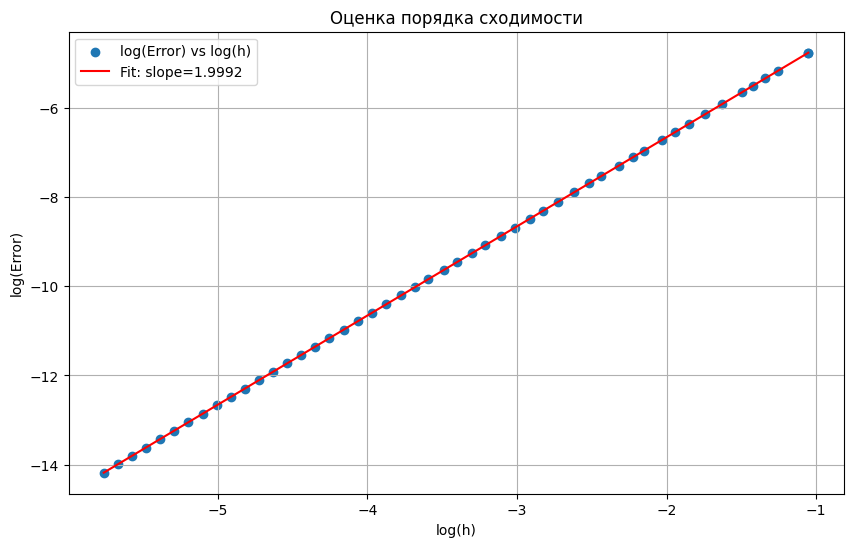

In [18]:
# --- Оценка сходимости ---
loss  = []
steps = np.logspace(1, 3, 50, dtype=int)

print("\nВычисление порядка сходимости...")
for n_step in tqdm(steps):
    solution, x_grid, t_grid = weighted_scheme(a_coeff, f_zer, phi_truncated,
                l_bound, r_bound,
                sigma = sigma, # Кранк-Николсон для O(h^2)
                x_border = x_border , t_border = t_border,
                x_num = n_step, t_num = n_step) # Nx = Nt => tau ~ h


    true_value_trunc = np.zeros_like(solution)
    for i, t in enumerate(t_grid):
        true_value_trunc[i, :] = u_truncated(x_grid, t, num_terms=N_TERMS)

    loss.append(np.max(np.abs(solution[:, :] - true_value_trunc[:, :]))) # Макс ошибка 


def linear_regr(x, a, b):
    return (a*x + b)

h_values = x_border / (steps - 1)
log_h = np.log(h_values)
log_loss = np.log(np.array(loss))

valid_indices = np.isfinite(log_h) & np.isfinite(log_loss)
log_h_valid = log_h[valid_indices]
log_loss_valid = log_loss[valid_indices]

if len(log_h_valid) > 1:
    popt, pcov = curve_fit(linear_regr, log_h_valid, log_loss_valid)
    convergence_order = popt[0]
    print(f"\nРасчетный порядок сходимости (наклон прямой): {convergence_order:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(log_h_valid, log_loss_valid, label='log(Error) vs log(h)')
    x_plot = np.linspace(min(log_h_valid), max(log_h_valid), 100)
    plt.plot(x_plot, linear_regr(x_plot, popt[0], popt[1]), color='red', label=f'Fit: slope={convergence_order:.4f}')
    plt.xlabel("log(h)")
    plt.ylabel("log(Error)")
    plt.title("Оценка порядка сходимости")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("\nНедостаточно данных для оценки порядка сходимости.")

# Проверка при $\sigma = 1$, то есть для неявной схемы

Для проверки сходимости будем согласованно менять шаг по времени и по пространству: $\tau$ ~ $h^2$

Тогда в силу того, что для неявной схемы имеем слудующий порядок сходимости $O(\tau + h^2)$, то в силу подбора шага по времени имеем ассимптотику $O(h^2)$.


Вычисление порядка сходимости...


100%|██████████| 50/50 [00:16<00:00,  3.11it/s] 



Расчетный порядок сходимости (наклон прямой): 1.9693


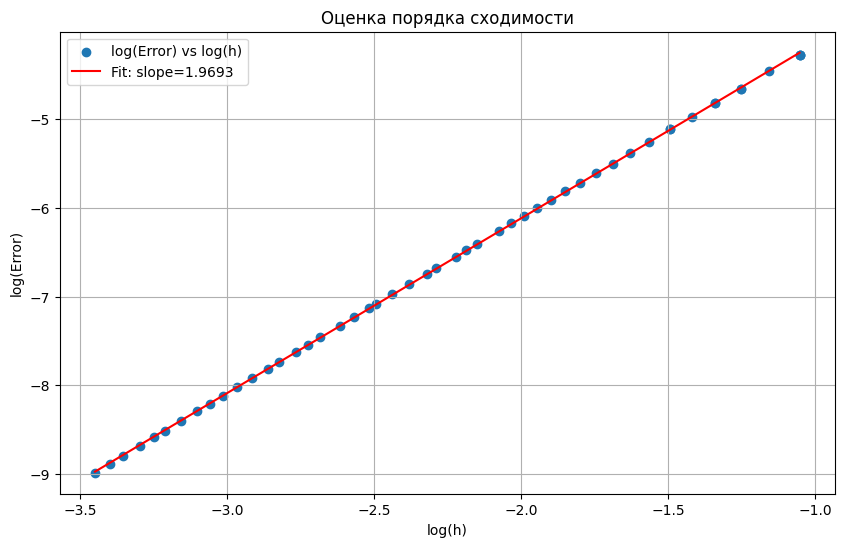

In [ ]:
# --- Оценка сходимости ---
loss  = []
steps = np.logspace(1, 2, 50, dtype=int)

print("\nВычисление порядка сходимости...")
for n_step in tqdm(steps):
    solution, x_grid, t_grid = weighted_scheme(a_coeff, f_zer, phi_truncated,
                l_bound, r_bound,
                sigma = 1, 
                x_border = x_border , t_border = t_border,
                x_num = n_step, t_num = n_step**2)


    true_value_trunc = np.zeros_like(solution)
    for i, t in enumerate(t_grid):
        true_value_trunc[i, :] = u_truncated(x_grid, t, num_terms=N_TERMS)

    loss.append(np.max(np.abs(solution[:, :] - true_value_trunc[:, :]))) # Макс ошибка 


def linear_regr(x, a, b):
    return (a*x + b)

h_values = x_border / (steps - 1)
log_h = np.log(h_values)
log_loss = np.log(np.array(loss))

valid_indices = np.isfinite(log_h) & np.isfinite(log_loss)
log_h_valid = log_h[valid_indices]
log_loss_valid = log_loss[valid_indices]

if len(log_h_valid) > 1:
    popt, pcov = curve_fit(linear_regr, log_h_valid, log_loss_valid)
    convergence_order = popt[0]
    print(f"\nРасчетный порядок сходимости (наклон прямой): {convergence_order:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(log_h_valid, log_loss_valid, label='log(Error) vs log(h)')
    x_plot = np.linspace(min(log_h_valid), max(log_h_valid), 100)
    plt.plot(x_plot, linear_regr(x_plot, popt[0], popt[1]), color='red', label=f'Fit: slope={convergence_order:.4f}')
    plt.xlabel("log(h)")
    plt.ylabel("log(Error)")
    plt.title("Оценка порядка сходимости")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("\nНедостаточно данных для оценки порядка сходимости.")

# Проверка при $\sigma = 0$, то есть для явной схемы

Для проверки сходимости будем согласованно менять шаг по времени и по пространству: $\tau$ ~ $h^2$

Тогда в силу того, что для неявной схемы имеем слудующий порядок сходимости $O(\tau + h^2)$, то в силу подбора шага по времени имеем ассимптотику $O(h^2)$.


Вычисление порядка сходимости...


100%|██████████| 50/50 [00:15<00:00,  3.17it/s] 



Расчетный порядок сходимости (наклон прямой): 2.0888


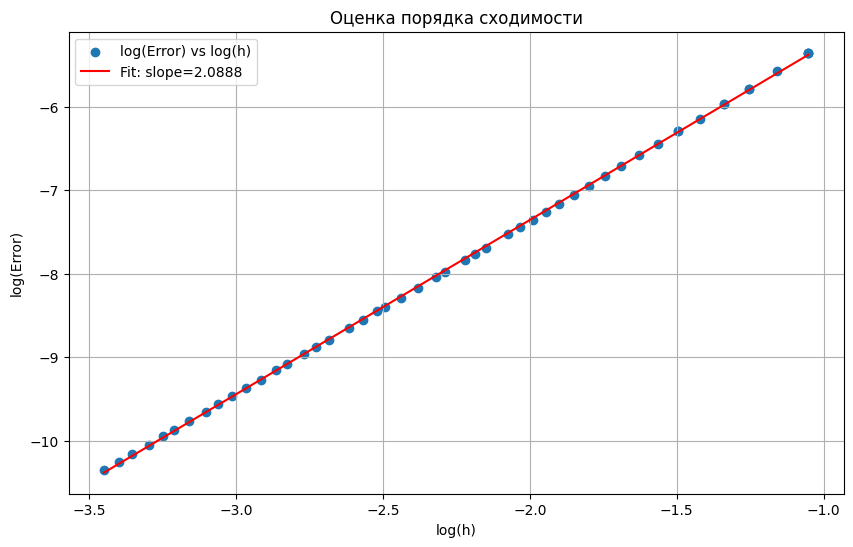

In [27]:
# --- Оценка сходимости ---
loss  = []
steps = np.logspace(1, 2, 50, dtype=int)

print("\nВычисление порядка сходимости...")
for n_step in tqdm(steps):
    solution, x_grid, t_grid = weighted_scheme(a_coeff, f_zer, phi_truncated,
                l_bound, r_bound,
                sigma = 0,
                x_border = x_border , t_border = t_border,
                x_num = n_step, t_num = n_step**2) 


    true_value_trunc = np.zeros_like(solution)
    for i, t in enumerate(t_grid):
        true_value_trunc[i, :] = u_truncated(x_grid, t, num_terms=N_TERMS)

    loss.append(np.max(np.abs(solution[-1:, :] - true_value_trunc[-1:, :]))) # Макс ошибка 


def linear_regr(x, a, b):
    return (a*x + b)

h_values = x_border / (steps - 1)
log_h = np.log(h_values)
log_loss = np.log(np.array(loss))

valid_indices = np.isfinite(log_h) & np.isfinite(log_loss)
log_h_valid = log_h[valid_indices]
log_loss_valid = log_loss[valid_indices]

if len(log_h_valid) > 1:
    popt, pcov = curve_fit(linear_regr, log_h_valid, log_loss_valid)
    convergence_order = popt[0]
    print(f"\nРасчетный порядок сходимости (наклон прямой): {convergence_order:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(log_h_valid, log_loss_valid, label='log(Error) vs log(h)')
    x_plot = np.linspace(min(log_h_valid), max(log_h_valid), 100)
    plt.plot(x_plot, linear_regr(x_plot, popt[0], popt[1]), color='red', label=f'Fit: slope={convergence_order:.4f}')
    plt.xlabel("log(h)")
    plt.ylabel("log(Error)")
    plt.title("Оценка порядка сходимости")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("\nНедостаточно данных для оценки порядка сходимости.")